In [0]:
# Run if you are executing this notebook in Colab to ensure tf v2.x.x
!pip install -U tensorflow keras

In [0]:
import math
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import tensorflow as tf
from keras import models, layers, datasets
from keras.callbacks import EarlyStopping

# A SF Permits Cleaning

### Methode um Y/NaN Spalten zu konvertieren

In [0]:
def replace_y_with_0_1(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Ersetzt Y und leere Felder in Spalten die nur Y und leere Felder erhalten durch 1 und 0 
    :param df: Dataframe in dem sich die Spalten befinden
    :param column: Name der Spalte in der die Werte ersetzt werden sollen
    :return: DataFrame mit modifizierten Spalten
    """
    df[column].fillna(0, inplace=True)
    df[column].replace('Y', 1, inplace=True)
    return df

### Datenset laden

In [0]:
permits_df = pd.read_csv("building_permits.csv")

c:\users\d074009\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# B SF Permits Exploration

# C SF Permits Prediction

### Methode für One-Hot-Encoding

In [0]:
def one_hot_encode(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Erzeugt Dummy-Spalten für jeden Wert in der Quell-Spalte.
    
    Beispiel:
    Wenn eine Tabelle die Spalte 'Klasse' mit 0, 1, 2 als Werte hat, werden die Spalte Klasse 0, Klasse 1 und Klasse 2
    erstellt und die Zeilen der Tabelle an den entsprechenden Stellen auf 0 bzw. 1 gesetzt. 
    :param df: Dataframe in dem die zu ersetzende Spalte ist
    :param col: Spalte die One-Hot-Encoded werden soll
    :return: modifizierter DataFrame
    """
    return df.assign(**{str(col + " " + str(val)): [1 if str(val) in str(cell) else 0 for cell in df[col]] 
                                   for val in df[col].unique()})

def days_between_dates(d1: str, d2: str) -> int:
    """
    Akzeptiert zwei Daten in der Form DD/MM/YYYY und berechnet die Tage zwischen den beiden Daten.
    :param d1: Erstes Datum
    :param d2: Zweites Datum
    :return: Anzahl der Tage zwischen den beiden Daten
    """
    d1 = d1.split("/")
    d2 = d2.split("/")
    if len(d1) != 3 or len(d2) != 3:
        raise ValueError("Date must consist of three numbers divided by '/'")
    d1 = datetime.date(int(d1[2]), int(d1[1]), int(d1[0]))
    d2 = datetime.date(int(d2[2]), int(d2[1]), int(d2[0]))
    return (d2 - d1).days

# D SF Challenges

# E Neural Networks XOR

![XOR Graph](https://github.com/maxmoehl/ATIT2_assignments/blob/master/Assignment_2/XOR.png?raw=1)

w: weight  
b: bias  
t: threshold

Mathematische Funktion:
```
SIGMOID(x) = 1 / (1 + e^(-x))
AND(x, y) = SIGMOID(50x + 50y - 75)
OR(x, y) = SIGMOID(50x + 50y - 25)
NOT(x) = SIGMOID(-50x + 10)

XOR(x, y) = AND(NOT(AND(x, y)), OR(x, y))

XOR(x,y) = SIGMOID(SIGMOID(SIGMOID(50x + 50y - 75) * (-50) + 10) * 50 + SIGMOID(50x + 50y - 25) * 50 - 75)
           \       \       \---------AND---------/             /        \                     /          /
            \       \-------------------NOT-------------------/          \--------OR---------/          /
             \-------------------------------------------AND-------------------------------------------/
```

### Funktionen in Python abbilden und testen

In [4]:
def SIGMOID(x):
    return 1 / (1 + (math.e ** (-x)))

def AND(x, y):
    return SIGMOID(x * 50 + y * 50 - 75)

def OR(x, y):
    return SIGMOID(x * 50 + y * 50 - 25)
    
def NOT(x):
    return SIGMOID(x * (-50) + 10)

def XOR(x, y):
    return AND(NOT(AND(x, y)),OR(x, y))

print(round(XOR(0, 0), 2))
print(round(XOR(0, 1), 2))
print(round(XOR(1, 0), 2))
print(round(XOR(1, 1), 2))

0.0
1.0
1.0
0.0


# F Neural Networks Overfitting

## Daten laden und splitten

Das größte Problem wenn man ein Modell hat das overfitted ist das man zu wenige Daten zum trainieren hat, um das hier zu simulieren verwenden wir nicht die 50.000 Datensätze zum trainieren sondern nur die 10.000.

In [5]:
(X_test, Y_test), (X_train, Y_train) = datasets.cifar10.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

num_classes = 10

170500096/170498071 [==============================] - 11s 0us/step


## Modell erstellen

Damit das Modell overfitted nehmen wir nur zwei Convolutional und ein MaxPooling Layer und zum auswerten auch nur ein Dense Layer.

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                108170    
Total params: 127,562
Trainable params: 127,562
Non-trainable params: 0
_________________________________________________________________


## Modell trainieren

Zusätzlich trainieren wir das Modell in 20 Epochen, das Modell wird sich also viel zu sehr an die 10.000 Datensätze die wir verwenden anpassen.

In [7]:
history = model.fit(X_train, Y_train, batch_size=100, epochs=20, validation_data=(X_test, Y_test))

Train on 10000 samples, validate on 50000 samples
Epoch 1/20
10000/10000 [==============================] - 34s 3ms/step - loss: 1.8640 - accuracy: 0.3366 - val_loss: 1.6231 - val_accuracy: 0.4279
Epoch 2/20
10000/10000 [==============================] - 34s 3ms/step - loss: 1.5130 - accuracy: 0.4629 - val_loss: 1.4850 - val_accuracy: 0.4748
Epoch 3/20
10000/10000 [==============================] - 33s 3ms/step - loss: 1.3665 - accuracy: 0.5199 - val_loss: 1.4044 - val_accuracy: 0.5083
Epoch 4/20
10000/10000 [==============================] - 33s 3ms/step - loss: 1.2594 - accuracy: 0.5592 - val_loss: 1.3722 - val_accuracy: 0.5153
Epoch 5/20
10000/10000 [==============================] - 33s 3ms/step - loss: 1.1956 - accuracy: 0.5838 - val_loss: 1.3470 - val_accuracy: 0.5278
Epoch 6/20
10000/10000 [==============================] - 33s 3ms/step - loss: 1.1235 - accuracy: 0.6103 - val_loss: 1.3015 - val_accuracy: 0.5441
Epoch 7/20
10000/10000 [==============================] - 33s 3ms/st

## Methode zum visualisieren der Ergebnisse

In [0]:
def plot_results(history, epoch_lim=20):
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.ylim([0, 2.5])
  plt.xlim([0, epoch_lim])
  plt.legend(loc='upper left')

## Ergebnisse visualisieren

Train accuracy: 90.17%
Test accuracy: 55.5%


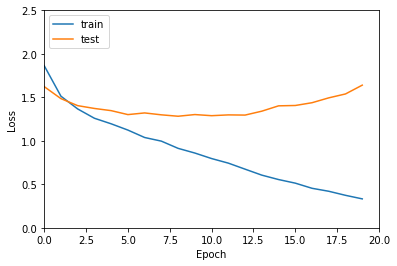

In [9]:
print("Train accuracy: {}%".format(round(history.history['accuracy'][-1] * 100, 2)))
print("Test accuracy: {}%".format(round(history.history['val_accuracy'][-1] * 100, 2)))
plot_results(history)

Wie man anhand des Graphen sehr gut sehen kann, steigt der Loss der Testdaten nach ca. 12 Epochen wieder an: das Modell overfitted. Das kann man auch an der Accuracy sehen, für die Trainingsdaten liegt die bei über 90% währrend die Testdaten nur um die 55% haben.

# G Neural Networks Overfitting

## Daten laden und splitten

Um jetzt in diesem Modell das Overfitting zu verhindern verwenden wir die 50.000 Datensätze zum lernen.

In [0]:
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()

X_train, X_test = X_train / 255.0, X_test / 255.0

num_classes = 10

## Modell erstellen

Damit das Modell die Muster in den Bildern besser erkennen kann fügen wir im Vergleich zu dem ersten Modell eine weitere Conv/MaxPooling Kombi und ein weiteres Dense Layer hinzu.

In [31]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)              

## Modell trainieren

Um Overfitting zu verhindern verringern wir die Anzahl an Epochen.

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
history = model.fit(X_train, Y_train, batch_size=10, epochs=15, validation_data=(X_test, Y_test), callbacks=[early_stopping])

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 106s 2ms/step - loss: 1.6400 - accuracy: 0.3914 - val_loss: 1.3406 - val_accuracy: 0.5171
Epoch 2/15
50000/50000 [==============================] - 104s 2ms/step - loss: 1.2924 - accuracy: 0.5390 - val_loss: 1.2690 - val_accuracy: 0.5482
Epoch 3/15
50000/50000 [==============================] - 101s 2ms/step - loss: 1.1615 - accuracy: 0.5889 - val_loss: 1.1041 - val_accuracy: 0.6162
Epoch 4/15
50000/50000 [==============================] - 101s 2ms/step - loss: 1.0742 - accuracy: 0.6245 - val_loss: 1.0711 - val_accuracy: 0.6281
Epoch 5/15
50000/50000 [==============================] - 102s 2ms/step - loss: 1.0151 - accuracy: 0.6454 - val_loss: 0.9853 - val_accuracy: 0.6638
Epoch 6/15
50000/50000 [==============================] - 101s 2ms/step - loss: 0.9653 - accuracy: 0.6644 - val_loss: 0.9457 - val_accuracy: 0.6751
Epoch 7/15
50000/50000 [==============================] - 102s

## Ergebnisse visualisieren

Train accuracy: 70.92%
Test accuracy: 68.63%


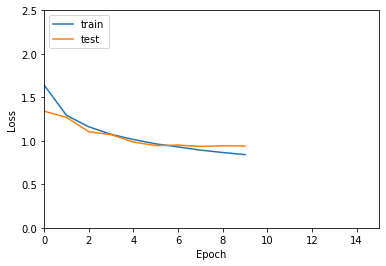

In [34]:
print("Train accuracy: {}%".format(round(history.history['accuracy'][-1] * 100, 2)))
print("Test accuracy: {}%".format(round(history.history['val_accuracy'][-1] * 100, 2)))
plot_results(history, epoch_lim=15)

Wie man an dem Graphen sehen kann sinkt der Loss sowohl für die Trainingsdaten als auch für die Testdaten kontinuierlich. Das Modell generalisiert wesentlich besser anstatt einfach nur die Bilder aus dem Trainingsset auswendig zu lernen. Der Early-Stop Callback verhindert, dass das Modell durch zu viele Trainingsepochen overfitted.  
Die Accuracy von Train und Test liegen auch sehr nah beieinander.

# H Feedback
### Wieviel Zeit habt ihr mit dem Assignment verbracht?
Max: 15h
### Wie oft habt ihr euch getroffen?
3
### Welche Aufgabe hat euch am besten gefallen?
### Welche Aufgabe hat euch am wenigsten gefallen?